In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn  as sbn
import re
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split

In [147]:
data_model = pd.read_csv('properati_cleaned3.csv')
data_model.shape

(120215, 11)

In [318]:
data_model.dtypes

place_name_new                     object
state_name_new                     object
description_new                    object
rooms_new                         float64
title_new                          object
property_type_new                  object
surface_total_in_m2_new           float64
currency_new                       object
price_new                         float64
price_aprox_local_currency_new    float64
price_usd_per_m2_new              float64
dtype: object

## SECCIÓN 5 - ANÁLISIS DE CORRELACIÓN

En este caso no podemos usar la covarianza para estimar la relación entre variables, ya que tenemos diferentes unidaeddes de medida (m2, dolares, cantidad de rooms, etc). 

Con lo cual estimamos una matriz de correlación.

Para cacular correlaciones no puede haber nulos en las columnas. Seleccionamos solamente las columnas numéricas.

In [148]:
matrix_corr = data_model[['rooms_new','price_new','surface_total_in_m2_new','price_usd_per_m2_new']].corr().round(3)
matrix_corr

,rooms_new,price_new,surface_total_in_m2_new,price_usd_per_m2_new
rooms_new,1.000,0.180,0.177,-0.098
price_new,0.180,1.000,0.150,0.252
surface_total_in_m2_new,0.177,0.150,1.000,-0.087
price_usd_per_m2_new,-0.098,0.252,-0.087,1.000


Le cambiamos los nombres a las columnas para que se vean mejor en el gráfico heatmap.

In [ ]:
data_model_graph = data_model.rename(columns={'rooms_new':'Ambientes',
                                   'price_new':'Precio',
                                   'surface_total_in_m2_new':'Superficie total en m2',
                                   'price_usd_per_m2_new':'Precio en dólares por m2'})

In [ ]:
matrix_corr_graph = data_model_graph[["Ambientes","Precio","Superficie total en m2","Precio en dólares por m2"]].corr().round(3)
matrix_corr_graph

Vemos que hay una correlaciones bajas por lo general, la correlacion mas alta obtenidad se da entre 'rooms_new' y 'surface_total_in_m2_new'

* Se realiza un grafico para poder verlo con mayor claridad

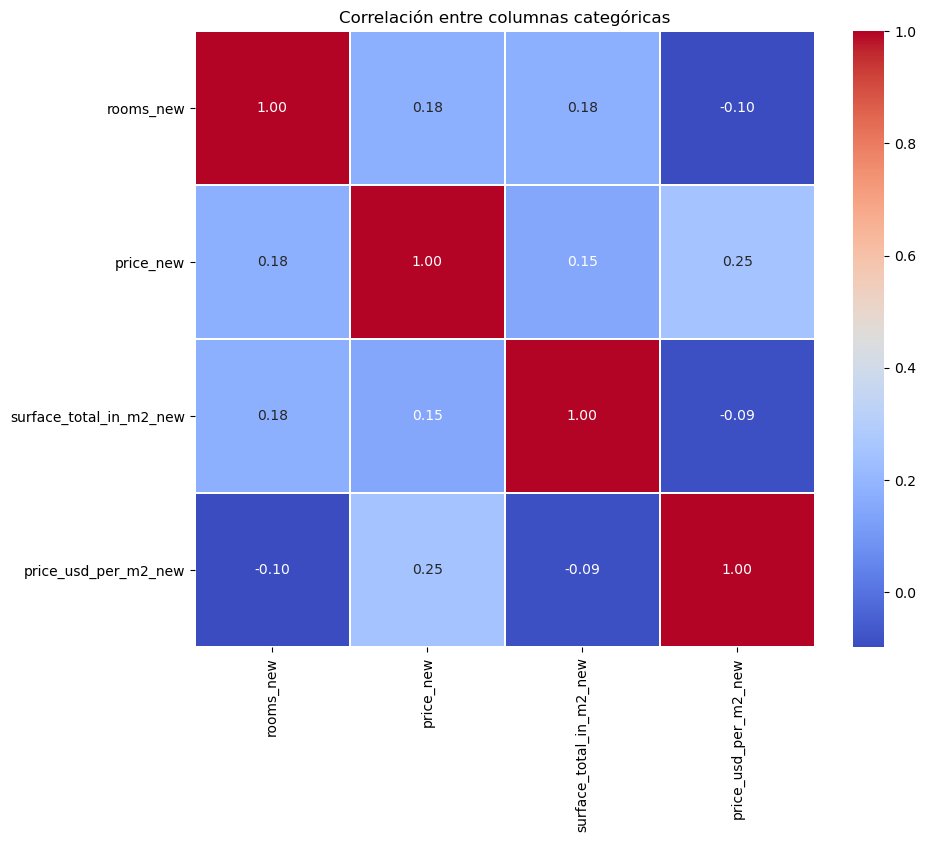

In [149]:
plt.figure(figsize=(10, 8))
sns.heatmap(matrix_corr_graph, annot=True, cmap='RdYlGn', fmt='.2f', linewidths=.5)
plt.title('Correlación entre columnas categóricas')
plt.show()

In [164]:
data_model.describe()

,rooms_new,surface_total_in_m2_new,price_new,price_aprox_local_currency_new,price_usd_per_m2_new
count,120215.000000,120215.000000,1.202150e+05,1.202150e+05,120215.000000
mean,2.655085,229.998703,2.360437e+05,4.164872e+06,2061.692426
std,1.224675,694.203152,3.547898e+05,6.260089e+06,3951.870785
min,1.000000,1.000000,4.666620e+03,8.234017e+04,0.600000
25%,2.000000,55.000000,9.541670e+04,1.683580e+06,840.336134
50%,2.000000,95.000000,1.501921e+05,2.650064e+06,1562.318841
75%,3.000000,261.000000,2.650000e+05,4.675792e+06,2361.111111
max,10.000000,50000.000000,4.654544e+07,8.212711e+08,600000.000000


## Sección gráfica

#### A continuación se puede ver la correlación para las dos variables númericas que utilizaremos para nuestro modelo. A medida que aumenta la sup. cubierta y la cantidad de cuartos, disminuye el precio por m2.

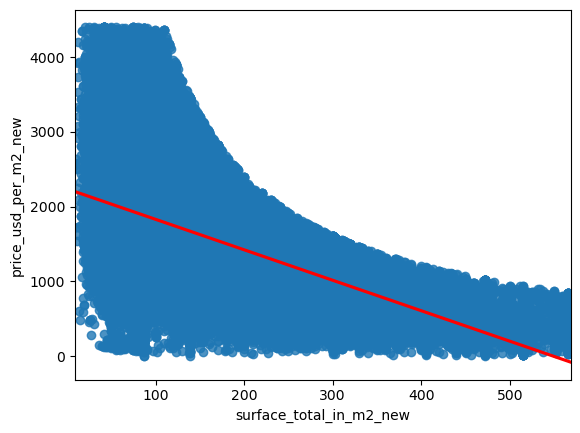

In [345]:
sns.regplot(data=data_model,x="surface_total_in_m2_new",y="price_usd_per_m2_new",line_kws=dict(color="r"), alpha=0.3)
plt.show()

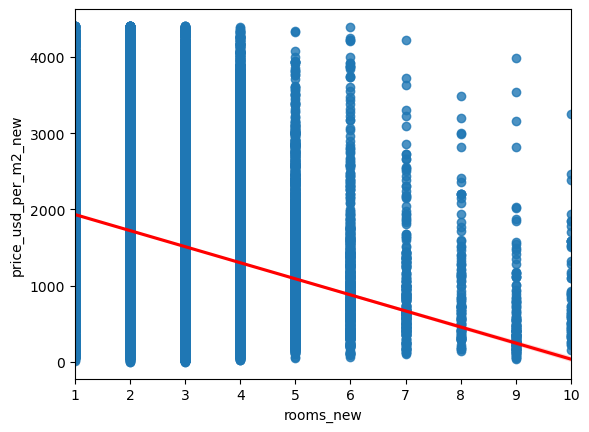

In [344]:
sns.regplot(data=data_model,x="rooms_new",y="price_usd_per_m2_new",line_kws=dict(color="r"))
plt.show()

### Análisis de variables categoricas

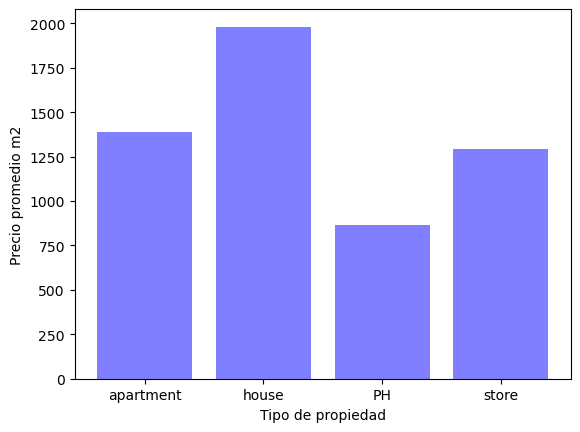

In [347]:
df_group_property = data_model.groupby('property_type_new')
df_resume = df_group_property ['price_usd_per_m2_new'].mean()

plt.bar(data_model["property_type_new"].value_counts().index,df_resume, color='b', alpha=0.5)
plt.xlabel("Tipo de propiedad")
plt.ylabel("Precio promedio m2")
plt.show()

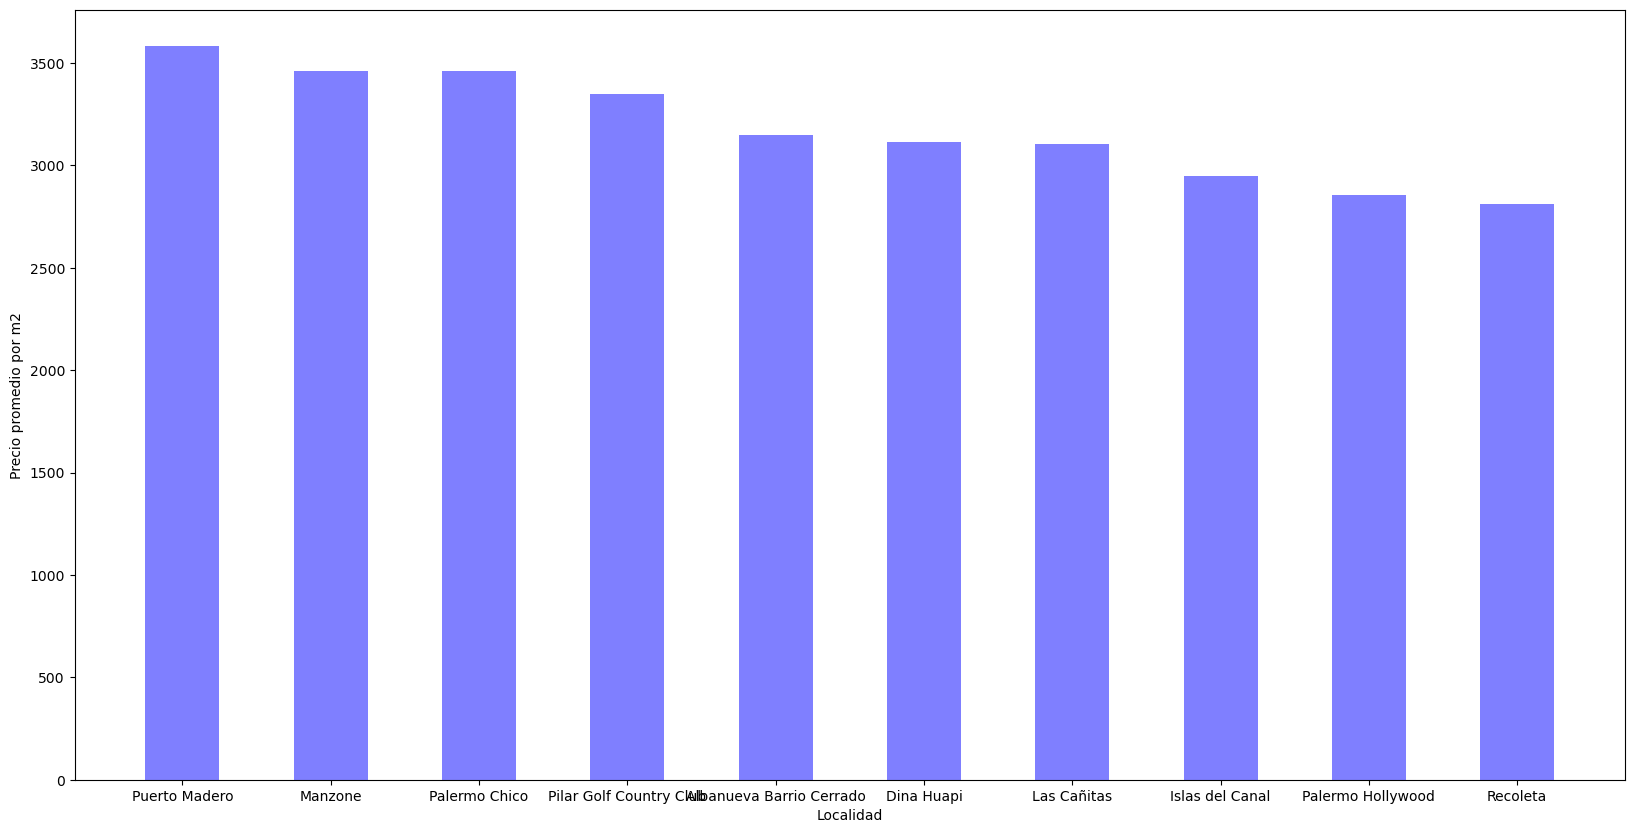

In [372]:
df_group_place_name = data_model.groupby('place_name_new')
df_resume = df_group_place_name ['price_usd_per_m2_new'].mean().sort_values(ascending=False).head(10)
plt.bar(df_resume.index,df_resume, color='b', alpha=0.5, width=0.5)
plt.rcParams["figure.figsize"] = (22,10)
plt.xlabel("Localidad")
plt.ylabel("Precio promedio por m2")
plt.show()

In [357]:
df_resume = df_group_place_name ['price_usd_per_m2_new'].mean().sort_values(ascending=False).head(10)
df_resume

place_name_new
Puerto Madero               3581.219028
Manzone                     3462.730510
Palermo Chico               3460.751355
Pilar Golf Country Club     3346.706897
Albanueva Barrio Cerrado    3149.009445
Dina Huapi                  3113.207547
Las Cañitas                 3102.606900
Islas del Canal             2949.869467
Palermo Hollywood           2857.480895
Recoleta                    2811.399637
Name: price_usd_per_m2_new, dtype: float64

### LIMPIEZA DE OUTLIERS. Se vuelven a limpiar porque al probar el modelo con el data set del TP1, las predicciones arrojan valores inconsistentes.

In [165]:
columnas = 'surface_total_in_m2_new', 'price_new', 'price_usd_per_m2_new'

for columna in columnas:
    columna_limpia = data_model[columna]

    q1 = columna_limpia.quantile(0.25)
    #print(q1)
    q3 = columna_limpia.quantile(0.75)
    #print(q3)
    iqr = (q3 - q1) * 1.5

    limite_sup = q3 + iqr
    limite_inf = 0
    
    print("Limite sup", columna, limite_sup)
    print("Limite inf", columna, limite_inf)
    
    outlier_mask_up = columna_limpia < limite_sup
    outlier_mask_down = columna_limpia > limite_inf
    outlier_mask = np.logical_and(outlier_mask_up, outlier_mask_down)
    
    data_model = data_model.loc[outlier_mask,:]

print(data_model.shape)
    

Limite sup surface_total_in_m2_new 570.0
Limite inf surface_total_in_m2_new 0
Limite sup price_new 483100.0
Limite inf price_new 0
Limite sup price_usd_per_m2_new 4406.715764774281
Limite inf price_usd_per_m2_new 0
(100569, 11)


In [166]:
cols = 'rooms_new', 'surface_total_in_m2_new', 'price_new', 'price_usd_per_m2_new'

for x in cols:
    missing_values = data_model[x].isna().sum()
    print(f"{x}: {missing_values}")    

rooms_new: 0
surface_total_in_m2_new: 0
price_new: 0
price_usd_per_m2_new: 0


### SE AGREGAN NUEVAS FEATURES AL MODELO DE DATOS

In [173]:
dummies_prop_type = pd.get_dummies(data_model.property_type_new, drop_first=True)
data_model_ml = pd.concat([data_model, dummies_prop_type], axis=1)

In [174]:
data_model_ml.head()

,place_name_new,state_name_new,description_new,rooms_new,title_new,property_type_new,surface_total_in_m2_new,currency_new,price_new,price_aprox_local_currency_new,price_usd_per_m2_new,apartment,house,store
0,Mataderos,Capital Federal,"2 ambientes tipo casa planta baja por pasillo,...",2.0,2 amb tipo casa sin expensas en pb,PH,55.000000,USD,62000.0,1093959.0,1127.272727,0,0,0
1,La Plata,Bs.As. G.B.A. Zona Sur,"venta de departamento en 10 piso al frente, a ...",2.0,venta depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,apartment,86.640712,USD,150000.0,2646675.0,1731.287716,1,0,0
2,Mataderos,Capital Federal,2 ambientes 3 piso lateral living comedor ampl...,2.0,2 amb 3 piso con ascensor apto credito,apartment,55.000000,USD,72000.0,1270404.0,1309.090909,1,0,0
3,Liniers,Capital Federal,ph 3 ambientes con patio. hay 3 deptos en lote...,3.0,ph 3 amb. cfte. reciclado,PH,137.729153,USD,95000.0,1676227.5,689.759561,0,0,0
4,Centro,Buenos Aires Costa Atlántica,departamento con fantastica iluminacion natura...,1.0,depto 2 amb al contrafrente zona centro/plaza ...,apartment,35.000000,USD,64000.0,1129248.0,1828.571429,1,0,0


### Se verifican las dummies agregadas, para sumar a los features

In [302]:
data_model_ml.columns

Index(['place_name_new', 'state_name_new', 'description_new', 'rooms_new',
       'title_new', 'property_type_new', 'surface_total_in_m2_new',
       'currency_new', 'price_new', 'price_aprox_local_currency_new',
       'price_usd_per_m2_new', 'apartment', 'house', 'store'],
      dtype='object')

In [303]:
data_model_ml.isnull().sum()

place_name_new                    0
state_name_new                    0
description_new                   0
rooms_new                         0
title_new                         0
property_type_new                 0
surface_total_in_m2_new           0
currency_new                      0
price_new                         0
price_aprox_local_currency_new    0
price_usd_per_m2_new              0
apartment                         0
house                             0
store                             0
dtype: int64

### SE CREA EL MODELO DE REGRESION LINEAL MULTIPLE

In [171]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets

In [195]:
# defino features y variable de estudio/target
features = ['rooms_new', 'surface_total_in_m2_new', 'price_new', 'apartment', 'house', 'store']

X = data_model_ml[features]
y = data_model_ml.price_usd_per_m2_new

In [196]:
# dividimos en conjuntos de datos para train y test del modelo
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state = 1)
x_train

,rooms_new,surface_total_in_m2_new,price_new,apartment,house,store
117136,2.0,86.640712,200000.000000,1,0,0
90415,2.0,63.000000,150000.000000,1,0,0
115822,1.0,34.000000,101209.000000,1,0,0
18577,3.0,137.729153,90000.000000,0,0,0
83208,2.0,131.000000,150000.000000,0,1,0
...,...,...,...,...,...,...
62350,2.0,94.000000,92546.155417,0,1,0
117309,3.0,112.000000,226000.000000,1,0,0
7014,3.0,138.981530,160000.000000,1,0,0
94242,3.0,231.000000,162000.000000,0,1,0


### Primero se escalan las features y se ajusta el modelo con statsmodels

In [204]:
# se escalan las features
scaler = MinMaxScaler()
scaler.fit(x_train)

std_numerical_data = scaler.transform(x_train)
x_train_s = pd.DataFrame(std_numerical_data)


In [205]:
# Restablecer los índices de X e y para asegurar que estén alineados
x_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

In [206]:
# Tenemos que agregar explícitamente a una constante:
x_train_c = sm.add_constant(x_train_s)

# creamos el modelo y lo ajustamos
model = sm.OLS(y_train, x_train_c).fit()

In [207]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     price_usd_per_m2_new   R-squared:                       0.666
Model:                              OLS   Adj. R-squared:                  0.666
Method:                   Least Squares   F-statistic:                 2.505e+04
Date:                  Wed, 14 Feb 2024   Prob (F-statistic):               0.00
Time:                          12:25:01   Log-Likelihood:            -5.8119e+05
No. Observations:                 75426   AIC:                         1.162e+06
Df Residuals:                     75419   BIC:                         1.162e+06
Df Model:                             6                                         
Covariance Type:              nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1310.4717      9.364    139.945      0.000    1292.118    1328.825
0           -918.2580     18.930    -48.508      0.000    -955.360    -881.156
1          -2368.4622     12.111   -195.560      0.000   -2392.200   -2344.724
2           2544.4416     10.740    236.915      0.000    2523.391    2565.492
3            352.6321      8.801     40.065      0.000     335.381     369.883
4            -22.4524     10.122     -2.218      0.027     -42.292      -2.612
5            292.8825     14.567     20.106      0.000     264.332     321.433
==============================================================================
Omnibus:                     7671.100   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10534.096
Skew:                           0.826   Prob(JB):                         0.00
Kurtosis:                       3.789   Cond. No.                         13.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### TESTEO del modelo

In [208]:
# Escalar las features de prueba con el mismo scaler utilizado para los datos de entrenamiento
std_numerical_data_test = scaler.transform(x_test)
x_test_s = pd.DataFrame(std_numerical_data_test)

# Agregar explícitamente la constante a los datos de prueba
x_test_c = sm.add_constant(x_test_s)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(x_test_c)

# Visualizar las predicciones
print(y_pred)


0        1980.578223
1        1704.124333
2        1669.594207
3        1258.901277
4        1757.191574
            ...     
25138    -421.514558
25139    1863.625129
25140    1335.685225
25141    1322.251755
25142    1123.075124
Length: 25143, dtype: float64


In [209]:
print ('R2:', metrics.r2_score(y_test, y_pred))
print ('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print ('MSE:', metrics.mean_squared_error(y_test, y_pred))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

R2: 0.6670832556228328
MAE: 422.9156493953739
MSE: 286887.0715839247
RMSE: 535.6184010878684


In [210]:
# SE REALIZA EL MISMO OMODULO UTILIZANDO LA LIBRERIA SKLEARN

In [213]:
# Instanciar el modelo
lm = linear_model.LinearRegression()

In [222]:
# Vuelvo a separar en TRAIN_TEST porque uso otra libreria.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35)
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model_skl = lm.fit(X_train, y_train)

In [223]:
# Entrenar el modelo con todo el dataset (no usaremos train-test-split en esta oportunidad)
#model_skl.fit(x_train, y_train) # TODO - ver porque al escalar las features(x_train_s) de entrenamiento el R2 da mal

In [224]:
# Testeo del modelo
yPred_skl = model_skl.predict(X_test)

In [225]:
print ('Intercept = ', model_skl.intercept_)
print ('RM = ', model_skl.coef_)

Intercept =  1615.2862697362607
RM =  [-112.29640835 -611.09922803  517.7276216   168.53819006  -11.8736607
   53.44070619]


In [226]:
print ('R2:', metrics.r2_score(y_test, yPred_skl))
print ('MAE:', metrics.mean_absolute_error(y_test, yPred_skl))
print ('MSE:', metrics.mean_squared_error(y_test, yPred_skl))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, yPred_skl)))

R2: 0.6660455440590223
MAE: 424.8987469505378
MSE: 289061.7181913952
RMSE: 537.6446021224385


In [227]:
# SE REALIZA REGULARIZACION PARA MEJORAR EL MODELO, ASI EVITANDO EL OVERFIT DEL MISMO

In [228]:
# USAMOS REGULARIZACION TIPO RIDGE CON CROSS VALIDATION

In [277]:
# instanciamos un modelo 
rlmcv = linear_model.RidgeCV(alphas=np.linspace(0.1, 100, 100), cv=3, normalize=False, scoring='r2')

In [278]:
rlmcv.alphas

array([  0.1       ,   1.10909091,   2.11818182,   3.12727273,
         4.13636364,   5.14545455,   6.15454545,   7.16363636,
         8.17272727,   9.18181818,  10.19090909,  11.2       ,
        12.20909091,  13.21818182,  14.22727273,  15.23636364,
        16.24545455,  17.25454545,  18.26363636,  19.27272727,
        20.28181818,  21.29090909,  22.3       ,  23.30909091,
        24.31818182,  25.32727273,  26.33636364,  27.34545455,
        28.35454545,  29.36363636,  30.37272727,  31.38181818,
        32.39090909,  33.4       ,  34.40909091,  35.41818182,
        36.42727273,  37.43636364,  38.44545455,  39.45454545,
        40.46363636,  41.47272727,  42.48181818,  43.49090909,
        44.5       ,  45.50909091,  46.51818182,  47.52727273,
        48.53636364,  49.54545455,  50.55454545,  51.56363636,
        52.57272727,  53.58181818,  54.59090909,  55.6       ,
        56.60909091,  57.61818182,  58.62727273,  59.63636364,
        60.64545455,  61.65454545,  62.66363636,  63.67

In [279]:
rlmcv.fit(X_train, y_train)

RidgeCV(alphas=array([  0.1       ,   1.10909091,   2.11818182,   3.12727273,
         4.13636364,   5.14545455,   6.15454545,   7.16363636,
         8.17272727,   9.18181818,  10.19090909,  11.2       ,
        12.20909091,  13.21818182,  14.22727273,  15.23636364,
        16.24545455,  17.25454545,  18.26363636,  19.27272727,
        20.28181818,  21.29090909,  22.3       ,  23.30909091,
        24.31818182,  25.32727273,  26.33636364,  27.34545455,
        28.35454545,  29.36363636...
        68.71818182,  69.72727273,  70.73636364,  71.74545455,
        72.75454545,  73.76363636,  74.77272727,  75.78181818,
        76.79090909,  77.8       ,  78.80909091,  79.81818182,
        80.82727273,  81.83636364,  82.84545455,  83.85454545,
        84.86363636,  85.87272727,  86.88181818,  87.89090909,
        88.9       ,  89.90909091,  90.91818182,  91.92727273,
        92.93636364,  93.94545455,  94.95454545,  95.96363636,
        96.97272727,  97.98181818,  98.99090909, 100.        ]),
 

In [280]:
print("El mejor Alpha(lambda) de ajuste:", rlmcv.alpha_)

El mejor Alpha(lambda) de ajuste: 3.1272727272727274


In [281]:
print("r^2:", rlmcv.score(X_train, y_train))

r^2: 0.6662509075450568


In [282]:
yPred_R = rlmcv.predict(X_test)

In [283]:
print("r^2 test:", rlmcv.score(X_test, y_test))

r^2 test: 0.66604592929673


In [284]:
print ('R2:', metrics.r2_score(y_test, yPred_R))
print ('MAE:', metrics.mean_absolute_error(y_test, yPred_R))
print ('MSE:', metrics.mean_squared_error(y_test, yPred_R))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, yPred_R)))

R2: 0.66604592929673
MAE: 424.8930925833882
MSE: 289061.38474031613
RMSE: 537.6442920187251


In [285]:
# USAMOS REGULARIZACION TIPO LASSO CON CROSS VALIDATION

In [287]:
lassocv = linear_model.LassoCV(alphas=np.linspace(0.01, 100, 1000), cv=3, normalize=False)

In [288]:
lassocv.fit(X_train, y_train)

LassoCV(alphas=array([1.00000000e-02, 1.10090090e-01, 2.10180180e-01, 3.10270270e-01,
       4.10360360e-01, 5.10450450e-01, 6.10540541e-01, 7.10630631e-01,
       8.10720721e-01, 9.10810811e-01, 1.01090090e+00, 1.11099099e+00,
       1.21108108e+00, 1.31117117e+00, 1.41126126e+00, 1.51135135e+00,
       1.61144144e+00, 1.71153153e+00, 1.81162162e+00, 1.91171171e+00,
       2.01180180e+00, 2.11189189e+0...
       9.76979279e+01, 9.77980180e+01, 9.78981081e+01, 9.79981982e+01,
       9.80982883e+01, 9.81983784e+01, 9.82984685e+01, 9.83985586e+01,
       9.84986486e+01, 9.85987387e+01, 9.86988288e+01, 9.87989189e+01,
       9.88990090e+01, 9.89990991e+01, 9.90991892e+01, 9.91992793e+01,
       9.92993694e+01, 9.93994595e+01, 9.94995495e+01, 9.95996396e+01,
       9.96997297e+01, 9.97998198e+01, 9.98999099e+01, 1.00000000e+02]),
        cv=3)

In [289]:
lassocv.coef_ 

array([-112.28522029, -611.08852717,  517.70880356,  168.52076147,
        -11.8850458 ,   53.42377426])

### vemos que usando lasso no se elimino ningun coeficiente . . . 

In [290]:
lassocv.intercept_

1615.2862697362607

In [291]:
print("r^2:", lassocv.score(X_train, y_train))

r^2: 0.6662509107953807


In [292]:
yPred_L = lassocv.predict(X_test)

In [293]:
print("r^2 test:", lassocv.score(X_test, y_test))

r^2 test: 0.666045884274945


In [294]:
print ('R2:', metrics.r2_score(y_test, yPred_L))
print ('MAE:', metrics.mean_absolute_error(y_test, yPred_L))
print ('MSE:', metrics.mean_squared_error(y_test, yPred_L))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, yPred_L)))

R2: 0.666045884274945
MAE: 424.89795996575305
MSE: 289061.4237099249
RMSE: 537.6443282597938
